# Guitar Audio Analysis via FFT  
This project applies Fast Fourier Transform (FFT) techniques to recorded audio samples of guitar strings and chords.  
The goal is to extract frequency-domain information, identify the fundamental frequencies present, and map them to musical notes and chords.

---

**Key steps in this analysis include:**
- Importing and visualizing guitar audio signals
- Performing FFT to extract dominant frequencies
- Mapping frequencies to musical notes
- Recognizing chords from note clusters


### Importing Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftfreq, fftshift

### Loading D chord audio File


We use mono `.wav` files of guitar strings and chords, which are loaded and converted to numerical arrays for analysis.


In [11]:
samplerate_dchord, V = wavfile.read('audio_signals/guitar-Dchord.wav')

### Functions definition for frequency and chord identification


Below are the key functions defined and used in this analysis:

- `find_freqs(signal, rate)`: Computes the FFT and extracts dominant frequencies.
- `find_notes(frequencies)`: Matches each frequency to the closest musical note.
- `find_chords(audio_path_file, reference_csv)`: Identifies possible chords based on known note combinations.

These functions enable modular and interpretable frequency-to-note analysis.

In [12]:
def find_freqs(V, sample_rate, M):

    ''' 
    Returns a series of frequencies ordered by energy density. 
    As the function deals with music notes, it skips 3 Hz, so that noise is not counnted twice. 
    
    Parameters
    -----------
    V: discrete signal

    sample_rate: int rate of sampling
    
    M: number of frequencies to be returned


    -----------
    '''
    N = len(V)

    # Getting total time of the audio
    tN = N / sample_rate

    #Getting the frequencies
    n = np.arange(-N/2,N/2,1)
    f = n / tN  
    
    # calculate the Fourier transform of V
    V_fft = fft(V, norm ='forward')

    #Calculate energy spectral density. Analytically we don't need to use the np.real function, but there are computational errors in handling variables
    S_n = np.real(V_fft * np.conjugate(V_fft))
    

    # We take only the positive frequencies here
    half_freq = int(len(f)/2)
    positive_f = f[half_freq:]
    
    # We shift to the zero frequency and then take only the energy densities corresponding to the positive frequencies
    positive_Sn = fftshift(S_n)[half_freq:] 
    peaks = np.empty(shape = (0,2))
    old_Sn = 0
    index = 0
    
    while index < len(positive_Sn):
        Sn = positive_Sn[index]
        if Sn > old_Sn:
            if Sn > positive_Sn[index+1] and Sn > positive_Sn[index+3]  and Sn > positive_Sn[index+7] and Sn > positive_Sn[index+11] and Sn > positive_Sn[index+15]:
            
                peaks = np.concatenate([peaks, [[Sn, positive_f[index]]]], axis=0)
                old_Sn = 0
                index += 20 # Skip 3.3 Hz
                if index > len(positive_Sn) - 23:
                    break
            else:
                index += 1
            
        else:
            old_Sn = Sn
            index += 1
    

    import pandas as pd

    df_peaks = pd.DataFrame(peaks, columns = ["Sn", "frequency / Hz"])
    sorted = df_peaks.sort_values(by="Sn", ascending= False)

    
    return sorted["frequency / Hz"].head(M)
  

In [13]:
def find_notes(V,sample_rate, M):
    
    ''' 
    Returns arrays of notes, their octaves and frequency, It calls the find_freqs() function. 
    This function has a nested function to find the note of each frequency, note_finder()
    Parameters
    -----------
    V: discrete signal

    sample_rate: rate of sampling
    
    M: number of frequencies to be returned

    -----------
    '''
    
    def note_finder(frequency):

        '''

        Finds note and octave of a particular frequency.

        '''
        
        notes = {16.35: 'C',17.32: 'C#',18.35: 'D', 19.45: 'D#', 20.60: 'E',21.83: 'F', 23.12: 'F#', 24.50: 'G', 25.96: 'G#',27.50: 'A',
                 29.14: 'A#',30.87: 'B'}
        octaves = [0,1,2,3,4,5,6,7]
        old_note = 16.35
    
        for octave in octaves:
            for note in notes:
                note = note *2**octave
                if frequency < note:
                    if abs(note-frequency) < abs(old_note - frequency):
             
                        return notes[note/2**octave], octave
                    else:

                        return notes[old_note/2**old_octave], old_octave
                    
              
                
                else:
                    old_octave = octave
                    old_note = note
    
  
    frequencies = find_freqs(V, sample_rate= sample_rate, M = M)
    notes = np.empty(shape = (0,3))
    for frequency in frequencies:
        note,octave= note_finder(frequency)
        notes= np.concatenate([notes, [[note, octave,frequency]]], axis=0)
    return notes
        


In [14]:
def identify_chord(path_file_audio, path_file_csv):
    
    '''
    
    Returns:
    -------
    chords: str
        List of recognized chords found in the major_chord.csv file. 
        This function has a nested function to find the note of each frequency, note_finder()
        
    Parameters
    -----------
    V: discrete signal

    sample_rate: rate of sampling

    M = 3, we consider the first three peaks of a signal to form a major chord

    -----------
    '''

    samplerate, V_chord = wavfile.read(path_file_audio) #Discrete sample

    found_notes = find_notes(V_chord, samplerate,M = 3) # Find the notes
    
    notes = [] # Empty list that will contain the notes exctracted from found_notes()
    
    for note in found_notes: # Putting the notes into a list 
        notes.append(note[0])

    major_chords = pd.read_csv(path_file_csv) #DataFrame object containing chords
    
    for i in range(len(major_chords)):
        if sorted(notes) == sorted(major_chords.loc[i][["note1","note2","note3"]].values):
            return major_chords.loc[i]["chord"]                          #Return the major chord found

    #If nothing is found this message will be returned instead
    return "No major chord identified"
    


## Visualizing Frequency Spectrum

We plot the frequency spectrum of individual guitar strings to verify the presence of expected fundamental tones and overtones.


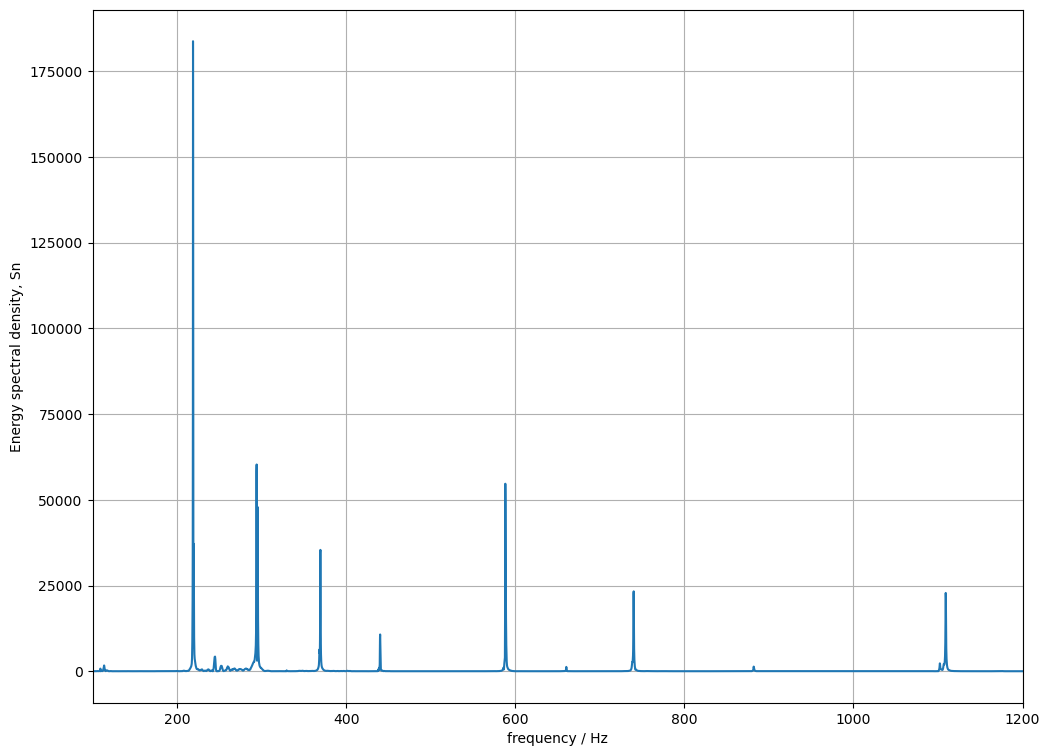

In [34]:
tN = len(V) / samplerate_dchord
N = len(V)

# calculate the Fourier transform of V
V_fft = fft(V, norm ='forward')

#Calculate energy spectral density. Analytically we don't need to use the np.real function, but there are computational errors in handling variables

S_n = np.real(V_fft * np.conjugate(V_fft))

n = np.arange(-N/2,N/2,1)

f = n / tN  
plt.figure(figsize =(12,9))
plt.grid(visible= True)
plt.plot(f, fftshift(S_n))
plt.xlabel('frequency / Hz')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(100,1200);

## Identifying Notes from Audio Files

Using the FFT-derived frequency peaks, we identify the closest matching musical notes for each recording.


In [17]:
find_freqs(V, samplerate_dchord, 6)

44      218.860035
55      294.124120
115     588.248239
71      369.553257
145     740.096831
220    1109.154930
Name: frequency / Hz, dtype: float64

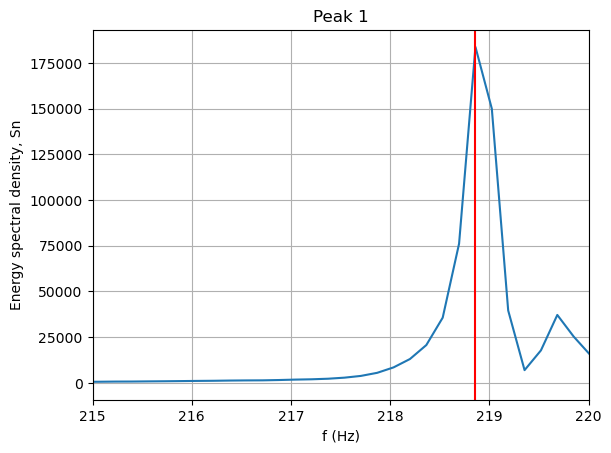

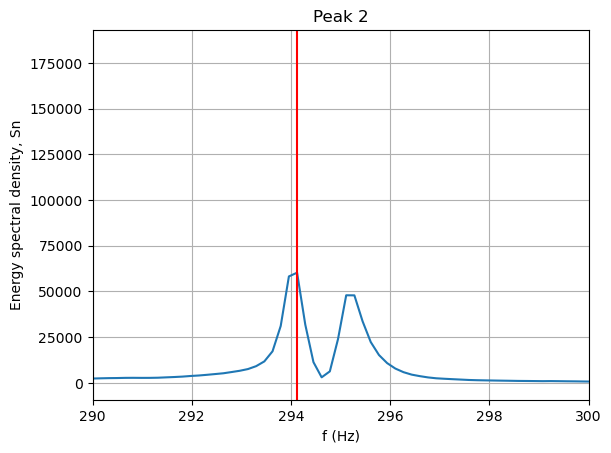

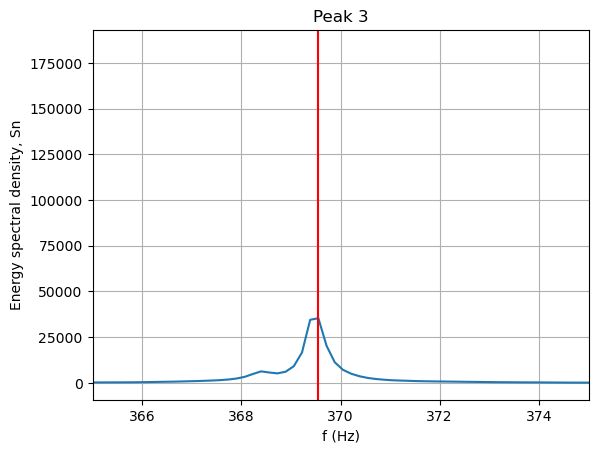

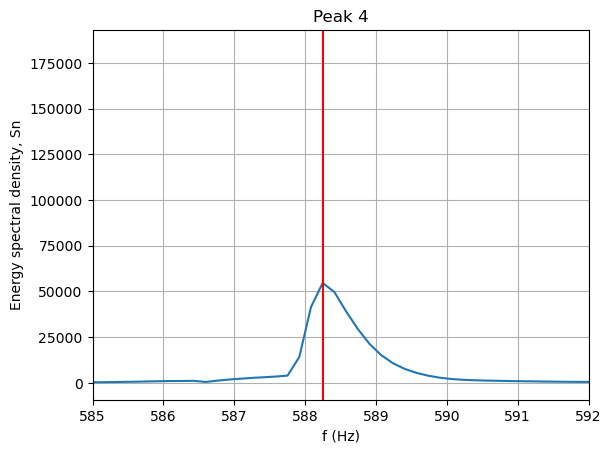

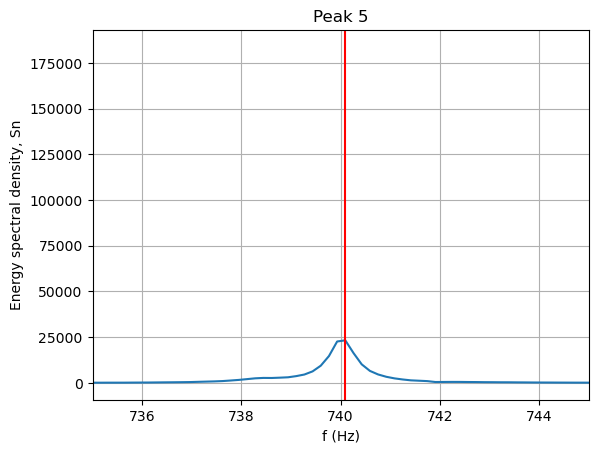

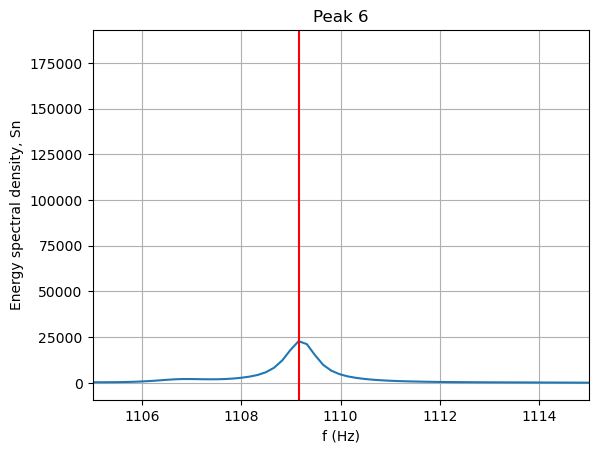

In [20]:
peak1, peak2, peak3, peak4, peak5, peak6 = find_freqs(V,samplerate_dchord, 6)
# We have 6 positive frequencies, we are going to plot and find the frequency of all these peaks now.



plt.plot(f, fftshift(S_n))
plt.grid(visible= True)
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(215,220)
plt.axvline(peak1, color = "red")
plt.title("Peak 1")
plt.show();


plt.plot(f, fftshift(S_n))
plt.grid(visible= True)
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(290,300)
plt.axvline(peak2, color = "red")
plt.title("Peak 2")
plt.show();

plt.plot(f, fftshift(S_n))
plt.grid(visible= True)
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(365,375)
plt.axvline(peak4, color = "red")
plt.title("Peak 3")
plt.show();

plt.plot(f, fftshift(S_n))
plt.grid(visible= True)
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(585,592)
plt.axvline(peak3, color = "red")
plt.title("Peak 4")
plt.show();

plt.plot(f, fftshift(S_n))
plt.grid(visible= True)
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(735,745)
plt.axvline(peak5, color = "red")
plt.title("Peak 5")
plt.show();

plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.grid(visible= True)
plt.ylabel('Energy spectral density, Sn')
plt.xlim(1105,1115)
plt.axvline(peak6, color = "red")
plt.title("Peak 6")
plt.show();

We can now use the find notes on the frequencies output and find the notes for each peak we plotted

In [27]:
for note in find_notes(V,samplerate_dchord, 6):
    print(note)

['A' '3' '218.86003521126761']
['D' '4' '294.1241197183099']
['D' '5' '588.2482394366198']
['F#' '4' '369.55325704225356']
['F#' '5' '740.0968309859155']
['C#' '6' '1109.1549295774648']


Hence the notes detected, ordered by energy spectral density are: `A3  D4  D5  F#4  F#5  C#6` 

## Detecting Chords from Guitar Audio

This section uses sets of detected notes to match against a reference dataset (`major_chords.csv`) and infer the likely played chord.
We use the identify_chord() function for this task:


In [29]:
chord1 = identify_chord(path_file_audio= "audio_signals//chord1.wav", path_file_csv= "major_chords.csv")
print(chord1)

No major chord identified


In [30]:
chord2 = identify_chord(path_file_audio= "audio_signals//chord2.wav", path_file_csv= "major_chords.csv")
print(chord2)

E


In [31]:
chord3 = identify_chord(path_file_audio= "audio_signals//chord3.wav", path_file_csv= "major_chords.csv")
print(chord3)

G


## Conclusion

This analysis highlights the capability of Fourier Transform techniques to extract musical information from raw audio signals. The approach can be extended to broader applications such as automated music transcription, audio classification, or real-time chord recognition.
